In [242]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from sklearn.metrics import accuracy_score,log_loss,precision_score,f1_score

from mlfinlab.cross_validation.cross_validation import ml_get_train_times,ml_cross_val_score,PurgedKFold
from mlfinlab.feature_importance.importance import (mean_decrease_impurity, mean_decrease_accuracy,
                                                    single_feature_importance, plot_feature_importance)
from mlfinlab.feature_importance.orthogonal import (feature_pca_analysis, get_pca_rank_weighted_kendall_tau,
                                                    get_orthogonal_features,_standardize_df,_get_eigen_vector)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score

from mlfinlab.backtest_statistics.statistics import (timing_of_flattening_and_flips, average_holding_period,
                                                     bets_concentration, all_bets_concentration,
                                                     drawdown_and_time_under_water, sharpe_ratio,
                                                     information_ratio, probabilistic_sharpe_ratio,
                                                     deflated_sharpe_ratio, minimum_track_record_length)
from mlfinlab.cross_validation.combinatorial import CombinatorialPurgedKFold
from mlfinlab.util.generate_dataset import get_classification_data 


import warnings
warnings.filterwarnings("ignore")

In [243]:
def getTestData(n_features=40,n_informative=10,n_redundant=10,n_samples=10000):
    # generate a random dataset for a classification problem
    #From: Advances in Financial Machine Learning 

    from sklearn.datasets import make_classification
    trnsX,cont=make_classification(n_samples=n_samples,
                                   n_features=n_features,
                                   n_informative=n_informative,
                                   n_redundant=n_redundant,
                                   random_state=0,
                                   shuffle=False)
    df0=pd.DatetimeIndex(periods=n_samples,freq=pd.tseries.offsets.BDay(), end=pd.datetime.today())
    trnsX,cont=pd.DataFrame(trnsX,index=df0), pd.Series(cont,index=df0).to_frame('bin')
    df0=['I_'+str(i) for i in range(n_informative)] + ['R_'+str(i) for i in range(n_redundant)]
    df0+=['N_'+str(i) for i in range(n_features-len(df0))]
    trnsX.columns=df0
    cont['w']=1./cont.shape[0]
    cont['t1']=pd.Series(cont.index,index=cont.index)
    return trnsX,cont

# Feature analysis

1) Generate synthetic Matrix (X,y) and peforme feature analysis: MDI, MDA and SFI

2) Mean Decrease Impurity (MDI) - In sample sample exclusive for tree-based classifiers

"At each node of each decision tree, the selected feature splits the subset it received in such a way that impurity is" [1]

3) Mean Decrease Accuracy (MDA) - Out of sample 

"Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS)method." [1]

4) Single Feature Analysis (SFI)

"Single feature importance (SFI) is a cross-section predictive-importance (out-of- sample) method. It computes the OOS performance score of each feature in isolation." [1]

[1] - Advances in Financial Machine Learning -Chapter 8

In [244]:
_,cont=getTestData(5,3,2,10)
xx,yy=get_classification_data(n_features=100,n_informative=2,n_redundant=80,n_samples=500,sigma=0.1)
data=xx
data['Y']=yy
yft=data.columns.values[-1]
xft=data.columns.values[:-1]

I - Informative features

R - Redundant features

N - Non-informative features (noise)

Y = Y(I,R)

In [245]:
xdata=data[xft]
ydata=data[yft]

n_estimator=1000
max_samples=10
rf=DecisionTreeClassifier(criterion='entropy',max_features=1,#None,
                          class_weight='balanced',min_weight_fraction_leaf=0.0)

rf=BaggingClassifier(base_estimator=rf,n_estimators=n_estimator,max_features=1.
                     #,max_samples=max_samples
                     ,oob_score=True)


rf.fit(xdata,ydata)
print ('Random Forest fitted')

numdays=len(xdata)
base = datetime.today()
t1 = [base - timedelta(days=x) for x in range(numdays,0,-1)]
t1=pd.DataFrame({'t1':t1})
t1=t1.set_index(t1.t1)
t1['t1']=t1['t1']
cv_gen=PurgedKFold(20,t1.t1)
oos_score = ml_cross_val_score(rf, xdata, ydata, cv_gen=cv_gen, scoring=log_loss).mean()

Random Forest fitted


### MDI

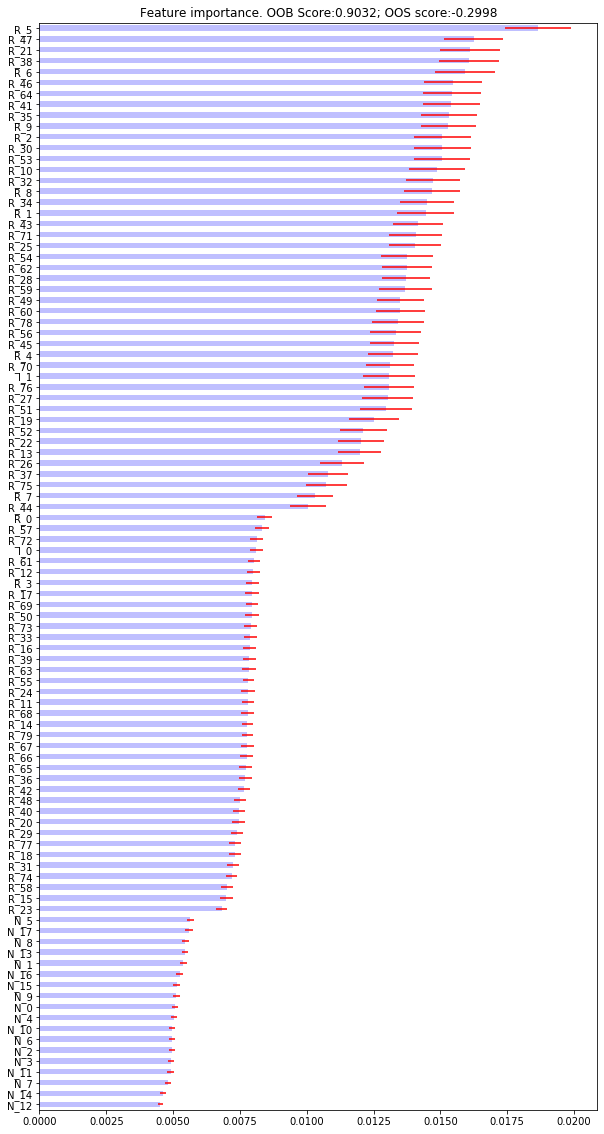

minimum importance: 0.01


In [246]:
mdi = mean_decrease_impurity(rf,xft)
plot_feature_importance(mdi,oob_score=rf.oob_score_, oos_score=oos_score)
print ('minimum importance:',1/len(xft))

### MDA

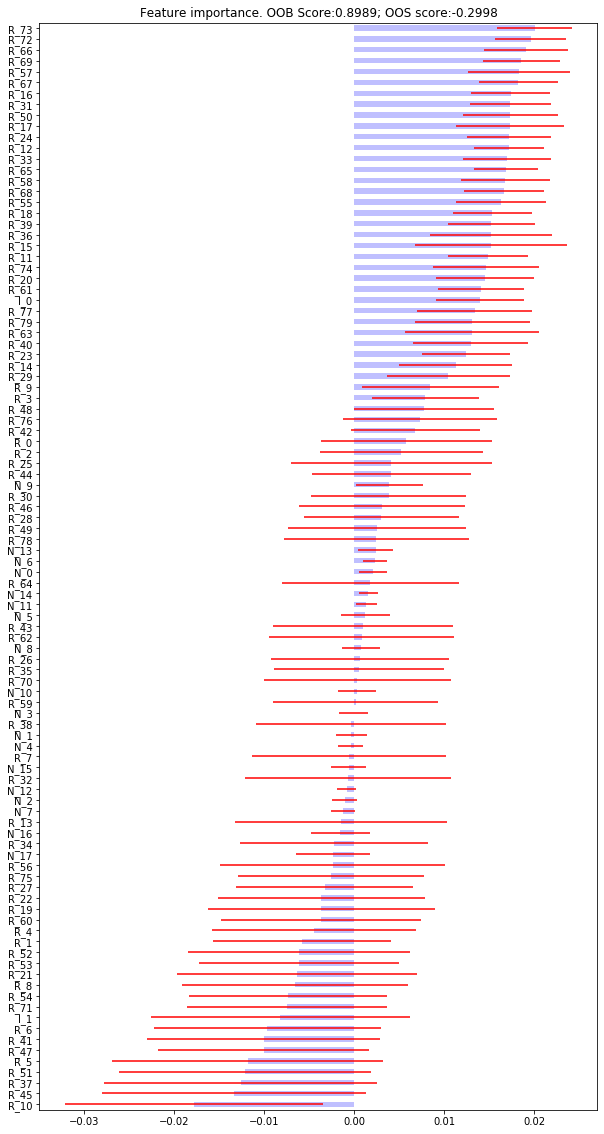

In [247]:
mda=mean_decrease_accuracy(rf,xdata,ydata,cv_gen,scoring=log_loss)

plot_feature_importance(mda,oob_score=rf.oob_score_, oos_score=oos_score)


### SFI

# PCA analysis

In [248]:
X=data[xft].copy()
Z=X.sub(X.mean(), axis=1).div(X.std(), axis=1)
ZtZ=pd.DataFrame(np.dot(Z.T,Z),index=X.columns,columns=X.columns)
eVal,eVec=np.linalg.eigh(ZtZ)
idx=eVal.argsort()[::-1]
eVal=eVal[idx]
th=0.95
eVal,eVec=_get_eigen_vector(ZtZ, th)

Xdot = pd.DataFrame(get_orthogonal_features(X,th), index=X.index).add_prefix("PCA_")
eVal=pd.Series(eVal.values,index=Xdot.columns)

print ('Eigen values:\n')
print (eVal)
print (Xdot.head())

Eigen values:

PCA_0     22579.560032
PCA_1     18195.184555
PCA_2       677.516706
PCA_3       623.315745
PCA_4       601.156972
PCA_5       588.839372
PCA_6       556.569107
PCA_7       545.024686
PCA_8       534.338404
PCA_9       521.561251
PCA_10      502.727318
PCA_11      487.408016
PCA_12      478.311082
PCA_13      459.227889
PCA_14      450.003009
dtype: float64
      PCA_0     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6  \
0 -0.727509  1.612293 -1.358227  0.650440 -0.545880  0.232887  0.656168   
1 -7.719239  3.836310 -1.135093 -1.021544 -0.756484 -0.187060 -1.086995   
2  5.583584 -1.248572 -1.014610  0.361838  1.684212  0.038338  0.431299   
3  3.802125 -1.459729 -0.123166  1.127942 -0.141165  0.719242 -1.031546   
4  3.375757 -2.432520 -0.577294 -0.625174  0.094352  1.821167 -0.700250   

      PCA_7     PCA_8     PCA_9    PCA_10    PCA_11    PCA_12    PCA_13  \
0  2.633242  0.211323  0.749122  0.526249 -0.030090 -0.794244  0.112436   
1 -1.373519 -1.492208  0

In [249]:
RANDOM_STATE=100
n_estimator=1000
maxsamples=1
rf=DecisionTreeClassifier(criterion='entropy',
                          max_features=1,#None,#1,
                          class_weight='balanced',
                          min_weight_fraction_leaf=0.0)

rf=BaggingClassifier(base_estimator=rf,
                     n_estimators=n_estimator,
                     max_features=1.,
                     #max_samples=maxsamples,
                     oob_score=True)

Y=np.sign(data[yft])
Xpca=Xdot.copy()

base = datetime.today()
numdays=len(Xpca)
t1 = [base - timedelta(days=x) for x in range(numdays,0,-1)]
t1=pd.DataFrame({'t1':t1})
t1=t1.set_index(t1.t1)
t1['t1']=t1['t1']
w=[1/len(cont) for x in range(numdays)]
w=pd.DataFrame({'w':w})
w=w.set_index(w.w)

rf.fit(Xpca,Y)
cv_gen=PurgedKFold(10,t1.t1)

### PCA MDI

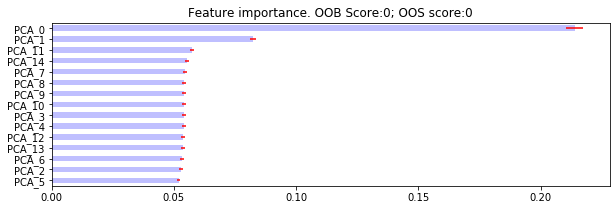

minimum importance: 0.01


{'Pearson': (0.04111945980531951, 0.5394690549191471),
 'Spearman': SpearmanrResult(correlation=0.12169811353920927, pvalue=0.06844246466878798),
 'Kendall': KendalltauResult(correlation=0.08422201879847874, pvalue=0.06799422007103434),
 'Weighted_Kendall_Rank': WeightedTauResult(correlation=0.5174072037331043, pvalue=nan)}

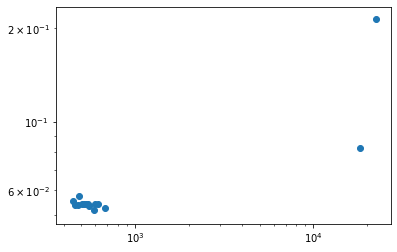

In [250]:
import matplotlib.pyplot as plt
imp = mean_decrease_impurity(rf,Xpca.columns)
plot_feature_importance(imp,0,0)
print ('minimum importance:',1/len(xft))
fig,aux=plt.subplots()
aux.scatter(eVal.loc[imp.index],imp['mean'])
aux.set_yscale('log')
aux.set_xscale('log')
aux.set_ylim([0.9*imp['mean'].values.min(),1.1*imp['mean'].values.max()])
aux.set_xlim([0.8*eVal.values.min(),1.2*eVal.values.max()])
feature_pca_analysis(Xpca,imp)

### PCA MDA

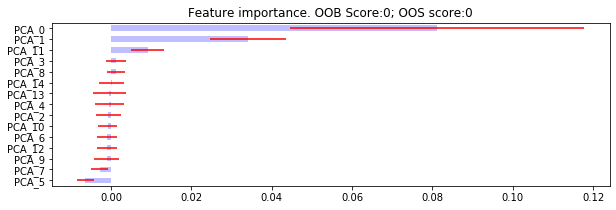

In [251]:
#MDA
imp=mean_decrease_accuracy(rf,Xpca,Y,cv_gen,scoring=log_loss)
plot_feature_importance(imp,0,0)


### PCA SFI

# Feature analysis

### Clustering

In [252]:
from mlfinlab.clustering.onc import get_onc_clusters
from mlfinlab.clustering.feature_clusters import get_feature_clusters
from sklearn.model_selection._split import KFold

clusters=get_feature_clusters(data[xft]
                              ,dependence_metric='linear'#'mutual_information'
                              #,distance_metric='angular'#None
                              #,linkage_method='single'#None
                              ,n_clusters=None)
clusters

No feature/s found with low silhouette score. All features belongs to its respective clusters


[['I_1',
  'R_1',
  'R_2',
  'R_4',
  'R_5',
  'R_6',
  'R_7',
  'R_8',
  'R_9',
  'R_10',
  'R_13',
  'R_19',
  'R_21',
  'R_22',
  'R_25',
  'R_26',
  'R_27',
  'R_28',
  'R_30',
  'R_32',
  'R_34',
  'R_35',
  'R_37',
  'R_38',
  'R_41',
  'R_43',
  'R_44',
  'R_45',
  'R_46',
  'R_47',
  'R_49',
  'R_51',
  'R_52',
  'R_53',
  'R_54',
  'R_56',
  'R_59',
  'R_60',
  'R_62',
  'R_64',
  'R_70',
  'R_71',
  'R_75',
  'R_76',
  'R_78'],
 ['I_0',
  'R_0',
  'R_3',
  'R_11',
  'R_12',
  'R_14',
  'R_15',
  'R_16',
  'R_17',
  'R_18',
  'R_20',
  'R_23',
  'R_24',
  'R_29',
  'R_31',
  'R_33',
  'R_36',
  'R_39',
  'R_40',
  'R_42',
  'R_48',
  'R_50',
  'R_55',
  'R_57',
  'R_58',
  'R_61',
  'R_63',
  'R_65',
  'R_66',
  'R_67',
  'R_68',
  'R_69',
  'R_72',
  'R_73',
  'R_74',
  'R_77',
  'R_79'],
 ['N_0',
  'N_1',
  'N_2',
  'N_3',
  'N_4',
  'N_5',
  'N_6',
  'N_7',
  'N_8',
  'N_9',
  'N_10',
  'N_11',
  'N_12',
  'N_13',
  'N_14',
  'N_15',
  'N_16',
  'N_17']]

In [253]:
clf_base = DecisionTreeClassifier(criterion='entropy'
                                  ,max_features=1
                                  ,class_weight='balanced'
                                  ,min_weight_fraction_leaf=0)

clf = BaggingClassifier(base_estimator=clf_base
                        ,n_estimators=1000
                        ,max_features=1.
                        ,max_samples=1.
                        ,oob_score=True
                        ,n_jobs=-1)
X=data[xft]
y=np.sign(data[yft])
fit = clf.fit(X,y)
cvGen = KFold(n_splits=10)
oos_score = ml_cross_val_score(clf, X, y, cv_gen=cvGen, scoring=log_loss).mean()

##### MDI cluster

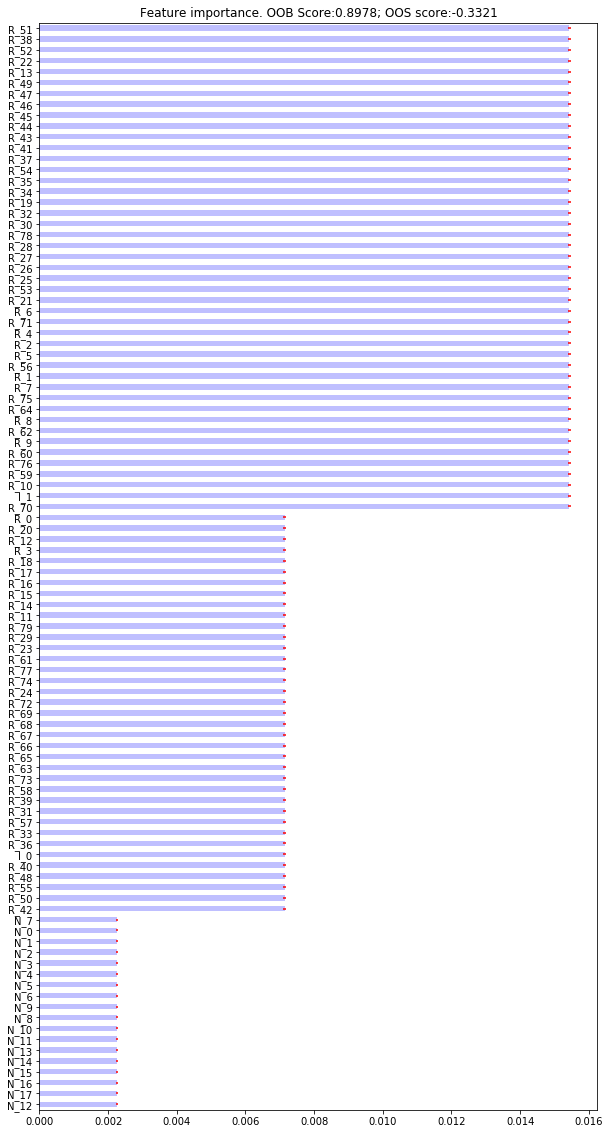

In [254]:
clustered_mdi_imp = mean_decrease_impurity(clf,X.columns,clustered_subsets=clusters)
plot_feature_importance(clustered_mdi_imp,oob_score=clf.oob_score_, oos_score=oos_score)

##### MDA cluster

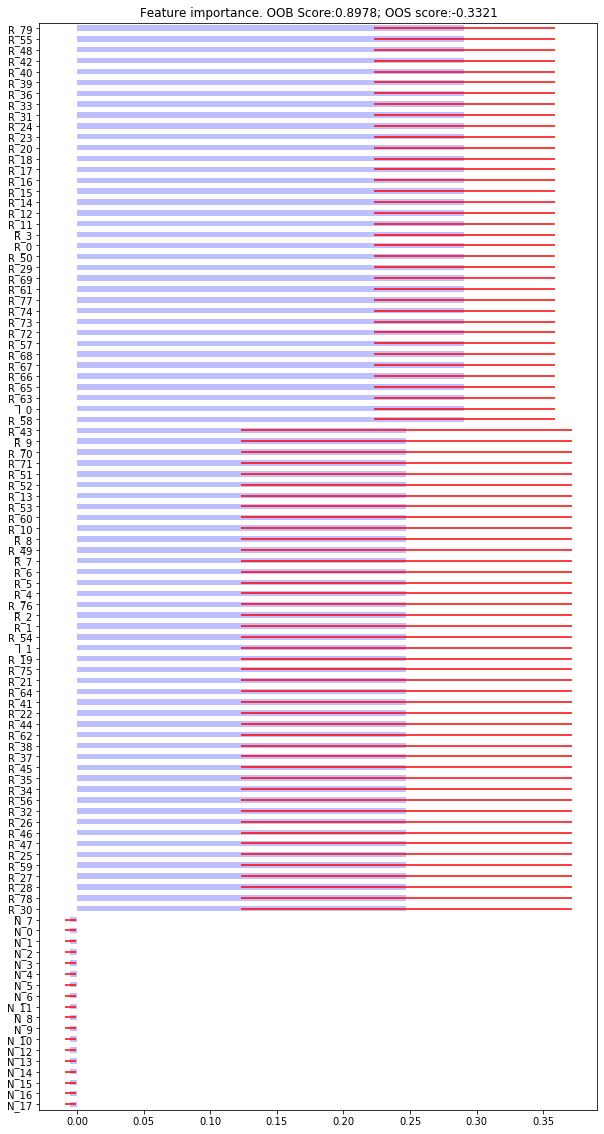

In [255]:
clustered_mda_imp = mean_decrease_accuracy(clf,X,y
                                           ,cv_gen=cvGen
                                           ,clustered_subsets=clusters
                                           ,random_state=0
                                           ,scoring=log_loss)
plot_feature_importance(clustered_mda_imp,oob_score=clf.oob_score_, oos_score=oos_score)

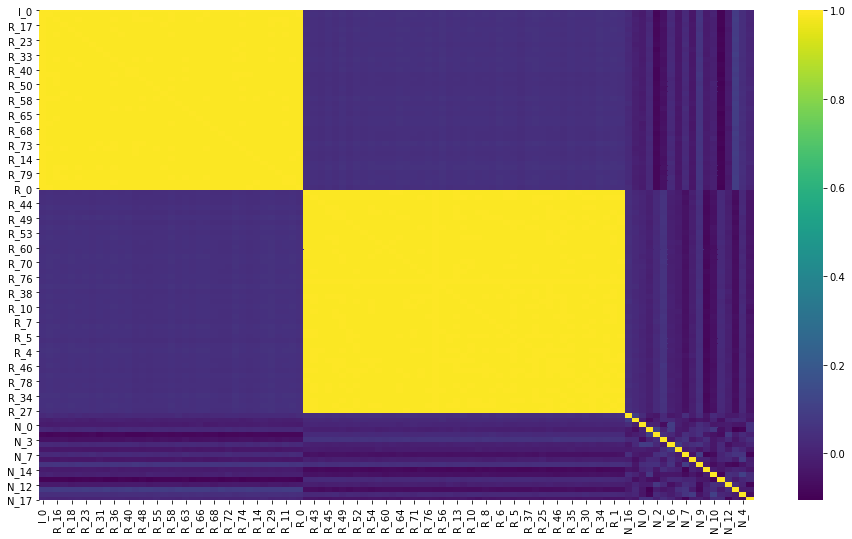

In [256]:
corr0,clstrs,silh = get_onc_clusters(X.corr())
plt.figure(figsize=(16,9))
sns.heatmap(corr0,cmap='viridis')